# Fishing Vessel Extended Loitering Model Development

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import (confusion_matrix, precision_score, recall_score,
                            f1_score, roc_auc_score, auc, precision_recall_curve,
                            matthews_corrcoef, mean_squared_error)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

In [77]:
data = pd.read_csv('data/final_data/final_data.csv')
# Further dropping variables with potential data leakage:
data = data.drop(['loitering_type', 'event_info_median_speed_knots', 'speed_variability',
                  'event_info_total_distance_km', 'event_info_loitering_hours'
                 ], axis=1)

## Initial Model Selection

In [ ]:
# Preprocess the data
def preprocess_data(df):
    """
    Preprocess the data for model training.
    """
    # Create a copy to avoid modifying the original dataframe
    df = df.copy()

    # Convert timestamp and ensure dates are sorted
    df['event_date'] = pd.to_datetime(df['event_date'])
    df = df.sort_values('event_date').reset_index(drop=True)

    # Simply convert time_since_last_loiter to total hours
    df['time_since_last_loiter'] = pd.to_timedelta(df['time_since_last_loiter'], errors='raise')
    df['time_since_last_loiter'] = df['time_since_last_loiter'].dt.total_seconds() / 3600  # Converts to hours

    categorical_cols = ['vessel_info_flag', 'event_info_origin_port.iso', 'event_info_destination_port.iso']
    # Use OneHotEncoder
    df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

    # Define features and target
    target = 'extended_loitering'
    features = df.columns.difference([target, 'event_date'])

    return df, features, target


# Create evaluation metrics function
def evaluate_model(y_true, y_pred, y_pred_proba):
    # Basic metrics
    conf_matrix = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()

    # Calculate recall for both classes
    recall_pos = tp / (tp + fn)
    recall_neg = tn / (tn + fp)

    metrics = {
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'Balanced_Accuracy': (recall_pos + recall_neg) / 2,
        'F1_Score': f1_score(y_true, y_pred),
        'ROC_AUC': roc_auc_score(y_true, y_pred_proba),
        'MCC': matthews_corrcoef(y_true, y_pred),
        'MSE': mean_squared_error(y_true, y_pred)
    }

    # Calculate PR-AUC
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    metrics['PR_AUC'] = auc(recall, precision)

    return metrics, conf_matrix

# Model training and evaluation function
def train_and_evaluate_models(df, features, target, n_splits=5):
    # Initialize TimeSeriesSplit with custom parameters
    tscv = TimeSeriesSplit(n_splits=n_splits, max_train_size=None)

    # Initialize models
    models = {
        'Logistic Regression': LogisticRegression(class_weight='balanced', random_state=RANDOM_STATE, max_iter=1000),
        'Decision Tree': DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM_STATE),
        'Random Forest': RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=RANDOM_STATE),
        'Gradient Boosting': GradientBoostingClassifier(random_state=RANDOM_STATE),
        'KNN': KNeighborsClassifier(n_neighbors=5)
    }

    # Prepare data
    X = df[features].values
    y = df[target].values

    # Store results
    results = {model_name: [] for model_name in models.keys()}
    confusion_matrices = {model_name: np.zeros((2, 2)) for model_name in models.keys()}

    # Perform cross-validation
    for train_idx, val_idx in tscv.split(X):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        # Scale features within the fold
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)

        for model_name, model in models.items():
            # Train model
            model.fit(X_train_scaled, y_train)

            # Make predictions
            y_pred = model.predict(X_val_scaled)
            y_pred_proba = model.predict_proba(X_val_scaled)[:, 1]

            # Calculate metrics
            metrics, conf_matrix = evaluate_model(y_val, y_pred, y_pred_proba)
            results[model_name].append(metrics)
            confusion_matrices[model_name] += conf_matrix

    # Average results across folds
    final_results = {}
    for model_name in models.keys():
        model_metrics = pd.DataFrame(results[model_name])
        final_results[model_name] = model_metrics.mean()

    return final_results, confusion_matrices


# Function to plot confusion matrices
def plot_confusion_matrices(confusion_matrices):
    n_models = len(confusion_matrices)
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()

    for idx, (model_name, conf_matrix) in enumerate(confusion_matrices.items()):
        if idx < len(axes):
            sns.heatmap(conf_matrix, annot=True, fmt='g', ax=axes[idx])
            axes[idx].set_title(f'{model_name} Confusion Matrix')
            axes[idx].set_xlabel('Predicted')
            axes[idx].set_ylabel('Actual')

    plt.tight_layout()
    return fig

# Set random state
RANDOM_STATE = 778

# Preprocess data
df_processed, features, target = preprocess_data(data)

# Train and evaluate models
results, confusion_matrices = train_and_evaluate_models(df_processed, features, target)

results_df = pd.DataFrame(results)

fig = plot_confusion_matrices(confusion_matrices)

## Model Evaluation

In [87]:
# Evaluation Metrics
results_df

,Logistic Regression,Decision Tree,Random Forest,Gradient Boosting,KNN
Precision,0.245196,0.258363,0.624286,0.617439,0.344702
Recall,0.618922,0.250506,0.014955,0.188151,0.071804
Balanced_Accuracy,0.707566,0.587477,0.507166,0.587720,0.528956
F1_Score,0.351128,0.253810,0.029016,0.286990,0.116655
ROC_AUC,0.756935,0.587477,0.821668,0.843135,0.639343
MCC,0.285870,0.176816,0.084636,0.305911,0.119298
MSE,0.219821,0.140090,0.095185,0.089026,0.101792
PR_AUC,0.326770,0.290381,0.357529,0.414933,0.197732


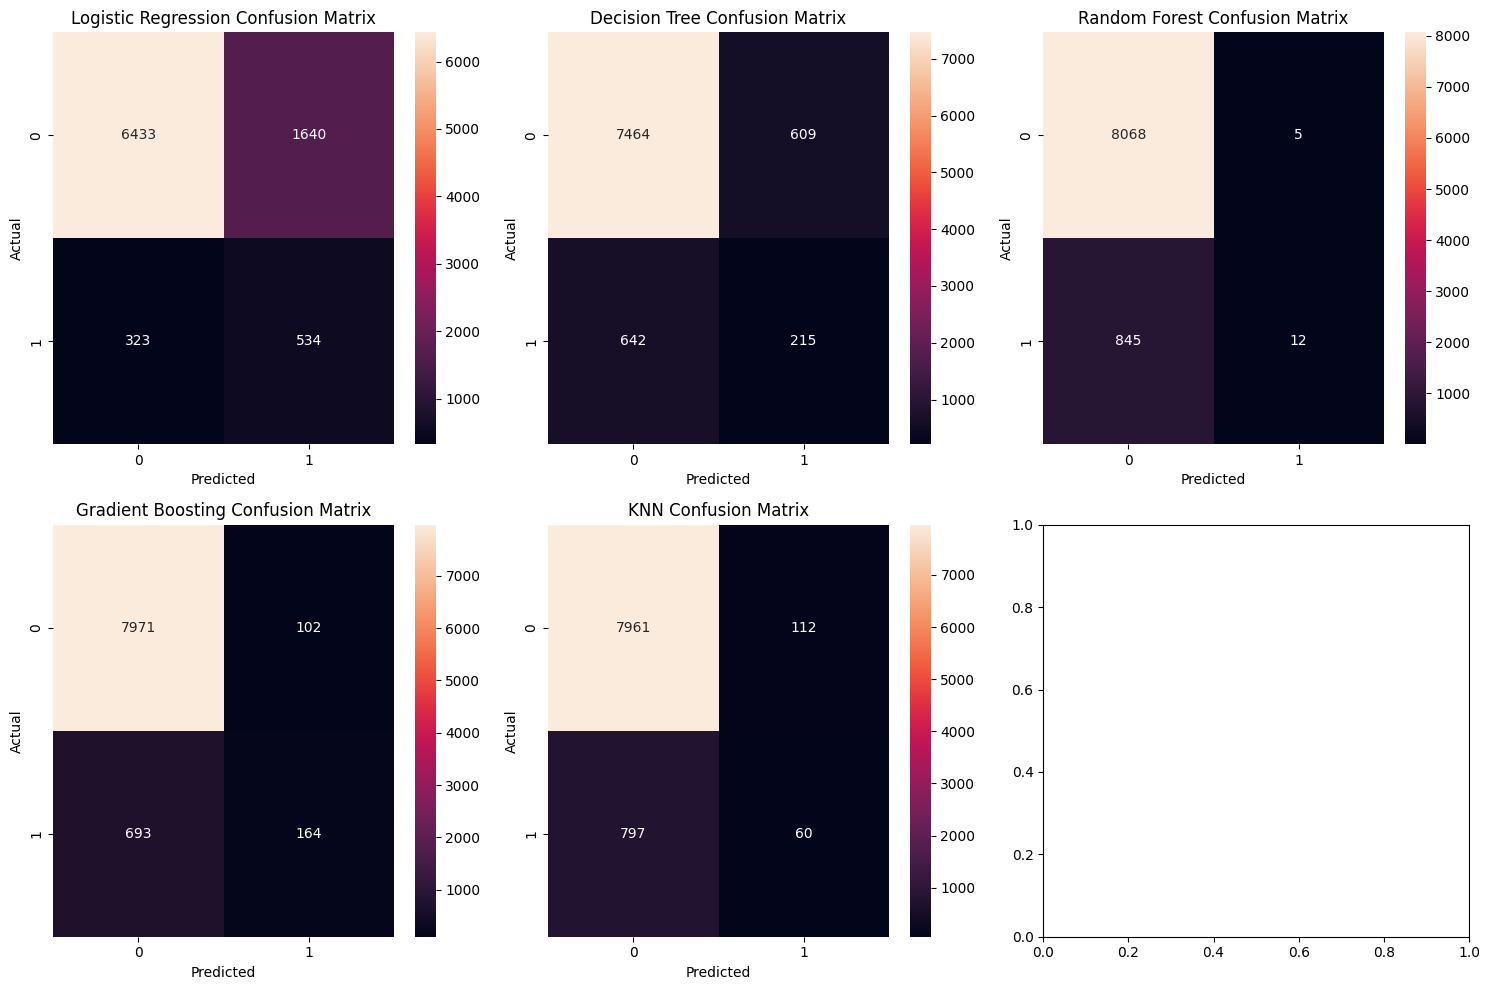

In [88]:
# Plot Confusion Matrix
fig

## Selected Model Refining
Based on initial model results, we will select Gradient Boosting model to continue further improvements
Gradient Boosting appears to be the best overall choice because:
- Highest PR-AUC (0.415) - important for imbalanced data
- Best MSE (0.089)
- Strongest MCC (0.306) - good indicator for imbalanced classifications
- Highest ROC-AUC (0.843)
- Good balance between precision (0.617) and recall (0.188)
- Reasonable balanced accuracy (0.588)

False negatives (missed extended loitering predictions) and false positives (incorrect predictions of extended loitering) both have operational costs. Gradient boosting provides a good balance between precision and recall

Optimizing XGBoost model...
Fitting 5 folds for each of 100 candidates, totalling 500 fits

Best parameters found:
colsample_bytree: 0.831212388844395
learning_rate: 0.048022198907298586
max_depth: 3
n_estimators: 123
scale_pos_weight: 9.6839481555334
subsample: 0.9594476112462684

Evaluating optimized model...

Optimized Model Performance Metrics:
Precision            0.251119
Recall               0.699711
Balanced_Accuracy    0.739097
F1_Score             0.367938
ROC_AUC              0.842027
MCC                  0.319395
MSE                  0.227212
PR_AUC               0.423930
dtype: float64


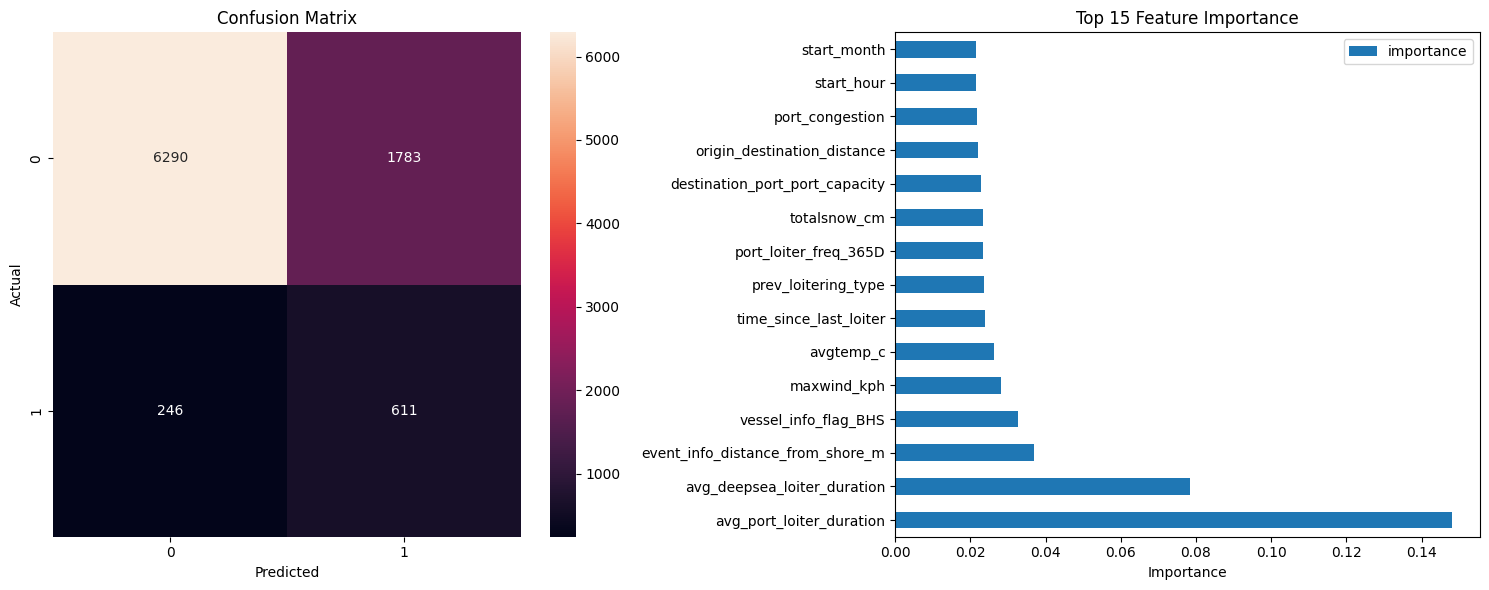

In [101]:
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier


def optimize_xgb_model(df, features, target, n_splits=5, n_iter=100):
    """
    Optimize Gradient Boosting model using RandomizedSearchCV with time series split.
    """
    # Prepare data
    X = df[features].values
    y = df[target].values

    # Define parameter space
    param_distributions = {
        'classifier__n_estimators': randint(100, 500),
        'classifier__learning_rate': uniform(0.01, 0.3),
        'classifier__max_depth': randint(3, 10),
        'classifier__subsample': uniform(0.6, 0.4),
        'classifier__colsample_bytree': uniform(0.6, 0.4),
        'classifier__scale_pos_weight': [float(np.sum(y == 0)) / np.sum(y == 1)]  # Ratio of negative to positive class
    }

    pipeline = Pipeline([
        ('classifier', XGBClassifier(random_state=RANDOM_STATE, eval_metric='logloss'))
    ])

    # Initialize TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # Initialize RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_distributions,
        n_iter=n_iter,
        cv=tscv,
        scoring='average_precision',
        random_state=RANDOM_STATE,
        n_jobs=-1,
        verbose=1
    )

    # Fit RandomizedSearchCV
    random_search.fit(X, y)

    return random_search.best_estimator_, random_search.best_params_

def evaluate_optimized_model(model, df, features, target, n_splits=5):
    """
    Evaluate the optimized model using time series cross-validation.
    """
    X = df[features].values
    y = df[target].values

    tscv = TimeSeriesSplit(n_splits=n_splits)
    results = []
    confusion_matrices = np.zeros((2, 2))
    feature_importances = []

    for train_idx, val_idx in tscv.split(X):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        # Scaling not needed for XGBoost
        X_train_scaled = X_train
        X_val_scaled = X_val

        # Fit the model
        model.fit(X_train_scaled, y_train)

        # Collect feature importances
        classifier = model.named_steps['classifier']
        feature_importances.append(classifier.feature_importances_)

        y_pred = model.predict(X_val_scaled)
        y_pred_proba = model.predict_proba(X_val_scaled)[:, 1]

        metrics, conf_matrix = evaluate_model(y_val, y_pred, y_pred_proba)
        results.append(metrics)
        confusion_matrices += conf_matrix

    # Average metrics across folds
    avg_metrics = pd.DataFrame(results).mean()

    # Average feature importances across folds
    avg_feature_importance = np.mean(feature_importances, axis=0)
    feature_importance_df = pd.DataFrame(
        avg_feature_importance,
        index=features,
        columns=['importance']
    ).sort_values('importance', ascending=False)

    return avg_metrics, confusion_matrices, feature_importance_df

def plot_results(confusion_matrix, feature_importance):
    """
    Plot confusion matrix and feature importance.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Plot confusion matrix
    sns.heatmap(confusion_matrix, annot=True, fmt='g', ax=ax1)
    ax1.set_title('Confusion Matrix')
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Actual')

    # Plot top 15 feature importance
    feature_importance.head(15).plot(kind='barh', ax=ax2)
    ax2.set_title('Top 15 Feature Importance')
    ax2.set_xlabel('Importance')

    plt.tight_layout()
    return fig


# Set random state
RANDOM_STATE = 778
np.random.seed(RANDOM_STATE)

# Preprocess data
df_processed, features, target = preprocess_data(data)

# Optimize model
print("Optimizing XGBoost model...")
best_model, best_params = optimize_xgb_model(df_processed, features, target)
print("\nBest parameters found:")
for param, value in best_params.items():
    clean_param = param.replace('classifier__', '')
    print(f"{clean_param}: {value}")

# Evaluate optimized model
print("\nEvaluating optimized model...")
metrics, conf_matrix, feature_importance = evaluate_optimized_model(
    best_model, df_processed, features, target
)

# Display results
print("\nOptimized Model Performance Metrics:")
print(metrics)

# Plot results
fig = plot_results(conf_matrix, feature_importance)
plt.show()
